In [1]:
import os
import numpy as np
import torch
import PIL
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch
import utils
import transforms as T
import matplotlib.pyplot as plt
import imageio
import random
from io import BytesIO
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import time

In [2]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
import os
import numpy as np
import torch
from PIL import Image


class SegpcDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted_alphanumeric(os.listdir(os.path.join(root, "x"))))
        self.masks = list(sorted_alphanumeric(os.listdir(os.path.join(root, "q"))))

    def __getitem__(self, idx):
        # load images ad masks
        #print(self.imgs[idx])
        img_path = os.path.join(self.root, "x", self.imgs[idx])
        mask_path = os.path.join(self.root, "q", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        #print(masks.shape)
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there are two classes
        label = np.ones(num_objs)
        
        labels = torch.as_tensor(label, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        #target["image_id"] = image_id
        #target["area"] = area
        #target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


def get_model_instance_segmentation(num_classes):
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

In [5]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #if train:
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
from engine import train_one_epoch, evaluate
import utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor



def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    
    num_classes = 2
    # use our dataset and defined transformations
    dataset = SegpcDataset('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train', get_transform(train=True))
    """
    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
    """
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    #model = get_model_instance_segmentation(num_classes)
    
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0025,
                                momentum=0.8, weight_decay=0.00025)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 2

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        #evaluate(model, data_loader_test, device=device)
        torch.save(model.state_dict(), '/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/weights/Fifth.pth')
    print("That's it!")


In [8]:
#main()

/home/richards/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


[{'boxes': tensor([[ 611.1128,  724.6746,  944.7574, 1043.5752],
        [ 577.5950,  245.3569,  881.4548,  546.1074],
        [ 156.7967, 1180.4552,  458.5856, 1494.7982],
        [ 980.5534,  617.9899, 1294.0381,  977.5160],
        [ 544.4713, 1054.2561,  927.0579, 1436.0021],
        [ 257.0465,  975.5785,  517.6473, 1235.4757],
        [ 327.6880,   40.1279,  557.1872,  273.3283],
        [ 692.9030,  733.5382,  915.9346,  928.1019],
        [ 496.7072,  510.4513,  756.7210,  772.3699],
        [1743.8126, 1003.4707, 2034.8096, 1207.9894],
        [1028.9384,  748.7357, 1267.8866,  970.8141],
        [ 649.2637,    7.1957,  930.9134,  239.5936],
        [ 263.2350,  986.3849,  429.3169, 1175.8871],
        [ 251.5057, 1285.4279,  457.8058, 1487.0073],
        [ 682.0032,  264.0269,  886.0006,  486.8667],
        [ 596.3208,   67.5648,  927.0388,  423.6555],
        [ 126.0508, 1012.4788,  520.2552, 1477.3234],
        [ 596.1183,  287.9880,  759.9979,  519.5735],
        [ 526.723

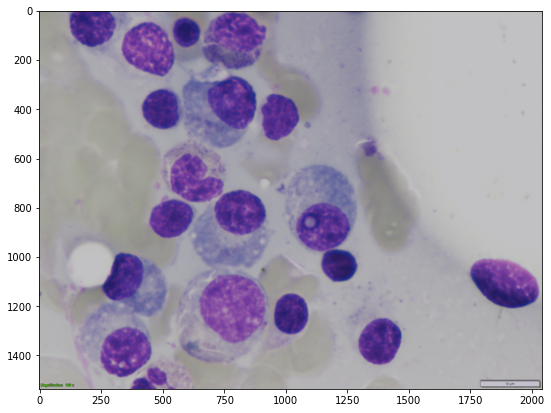

time:-4.46799635887146
[{'boxes': tensor([[1259.3809,  681.2900, 1596.9349, 1021.1140],
        [ 909.4703,  607.6718, 1231.5685,  923.5925],
        [1051.6765,  332.4219, 1403.1011,  671.5814],
        [1312.8359,  109.9945, 1628.6873,  473.3900],
        [1564.6348,  354.8059, 1932.6904,  749.1943],
        [ 307.2538,  912.7437,  607.7068, 1184.5460],
        [ 494.0915,  355.1228,  772.0125,  645.5883],
        [  59.8682,  209.2076,  320.6216,  505.9038],
        [ 236.8333,   54.0186,  566.7564,  393.5004],
        [ 232.7698,  635.7081,  527.4946,  924.8024],
        [1126.7646,  954.0987, 1554.7954, 1337.9833],
        [1069.3062,  380.2793, 1277.6364,  603.2952],
        [1513.0615, 1197.3201, 1768.4763, 1531.1346],
        [ 268.8662,  391.9067,  510.3811,  639.6609],
        [   0.0000,  492.3591,  246.7469,  844.3016],
        [1272.6707,  728.0452, 1480.9346,  979.3393],
        [1131.0857,  993.4739, 1322.7600, 1209.7197],
        [1699.6635,  371.5045, 1917.7712,  582.3

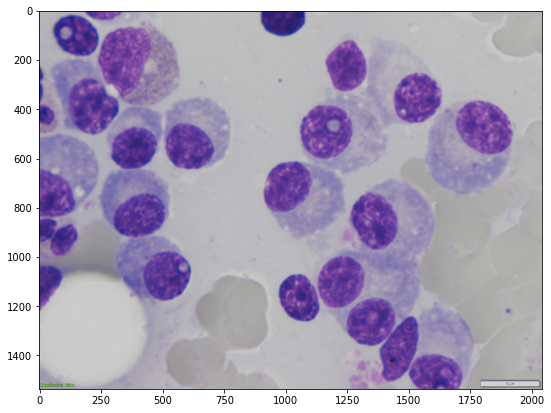

time:-3.007115602493286
[{'boxes': tensor([[1497.3749,  487.1719, 1759.1533,  788.6815],
        [ 816.7437,  926.0538, 1193.1163, 1284.4640],
        [ 705.9944,  700.3206, 1025.1353, 1026.5535],
        [1001.5477, 1138.2021, 1384.8796, 1517.1251],
        [ 552.8190,   65.7792,  904.8502,  422.2568],
        [ 680.0919,  350.5571, 1085.6580,  756.6263],
        [ 562.4266,  944.2736,  818.7206, 1241.2958],
        [1122.9543,  259.4508, 1374.1166,  520.7769],
        [1016.7999, 1279.7980, 1238.6656, 1497.8276],
        [ 883.4366,  138.5410, 1149.7213,  400.2385],
        [ 699.3878,  395.4433,  974.8894,  689.1628],
        [1630.0577,    8.8795, 1853.7219,  200.2388],
        [1704.9459,  118.8723, 2032.9321,  454.2768],
        [ 826.2133, 1068.1733, 1013.5750, 1285.8217],
        [ 731.3258,   96.4695,  914.0008,  338.0713],
        [ 578.1143,  951.1949,  769.1572, 1147.0780],
        [ 662.5139,  529.6484, 1082.5317,  980.7377],
        [1699.4866,  836.3608, 1986.4932, 1149.

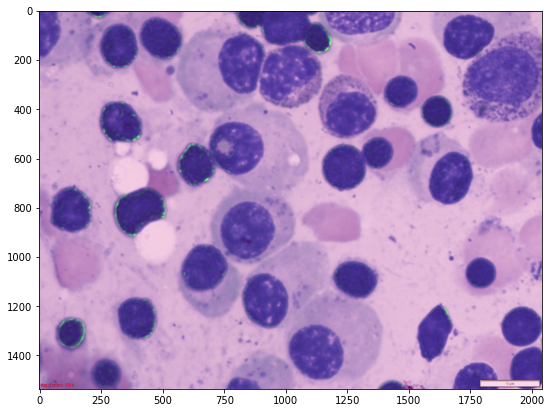

time:-3.0322399139404297
[{'boxes': tensor([[1.1032e+03, 8.1930e+02, 1.4408e+03, 1.1369e+03],
        [6.5281e+02, 5.0387e+00, 1.0253e+03, 3.6830e+02],
        [5.1851e+02, 4.7262e+02, 8.5776e+02, 7.8781e+02],
        [1.2126e+03, 3.6526e+02, 1.5535e+03, 7.0286e+02],
        [1.1503e+03, 1.1319e+03, 1.5058e+03, 1.4220e+03],
        [3.1940e+02, 0.0000e+00, 6.9056e+02, 2.6860e+02],
        [1.4635e+03, 5.4951e+02, 1.8364e+03, 9.0914e+02],
        [1.5240e+03, 1.0280e+03, 1.8638e+03, 1.4286e+03],
        [3.9174e+02, 4.5265e+01, 6.3517e+02, 2.4731e+02],
        [0.0000e+00, 2.6302e+02, 2.1449e+02, 6.4015e+02],
        [3.6557e+02, 1.1314e+03, 7.4115e+02, 1.4186e+03],
        [3.6315e+02, 8.8607e+02, 6.7271e+02, 1.1718e+03],
        [1.5362e+03, 5.5137e+02, 1.7706e+03, 7.4865e+02],
        [1.5730e+03, 1.1904e+03, 1.8139e+03, 1.4146e+03],
        [1.2850e+03, 4.7340e+02, 1.5343e+03, 6.9498e+02],
        [6.6206e+02, 5.3161e+02, 8.6879e+02, 7.6721e+02],
        [1.1936e+03, 9.3087e+02, 1.4

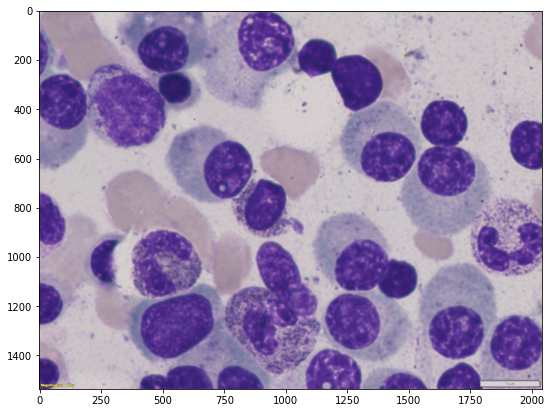

time:-2.9688093662261963
[{'boxes': tensor([[1229.4305, 1073.5862, 1562.0714, 1421.4359],
        [1166.6002,  520.2473, 1488.0034,  857.7391],
        [  27.8833,   89.4782,  373.2346,  477.3801],
        [1673.6968,  133.6971, 1977.7268,  497.7096],
        [  76.6782,   92.4850,  323.2565,  309.9241],
        [1240.9590, 1161.9967, 1445.4423, 1373.2996],
        [1697.0012,  145.7037, 1940.3732,  372.3849],
        [1272.2625,  615.2355, 1484.7889,  835.0957],
        [1542.9550, 1349.9004, 1730.8928, 1529.1843]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9376, 0.9323, 0.9041, 0.8828, 0.7908, 0.7562, 0.5239, 0.4744, 0.0524],
       grad_fn=<IndexBackward>)}]


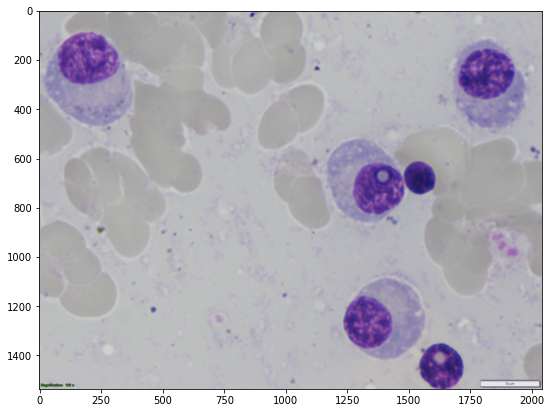

time:-2.9217138290405273
[{'boxes': tensor([[8.2832e+02, 1.1681e+03, 1.1165e+03, 1.5022e+03],
        [5.5423e+02, 1.1310e+03, 8.4249e+02, 1.4564e+03],
        [1.0430e+03, 1.0439e+03, 1.3375e+03, 1.3578e+03],
        [1.4181e+03, 8.7887e+02, 1.7454e+03, 1.2349e+03],
        [1.1878e+03, 0.0000e+00, 1.4833e+03, 3.0686e+02],
        [1.7264e+03, 9.3219e+02, 1.9892e+03, 1.2341e+03],
        [1.4102e+03, 5.0520e+02, 1.6549e+03, 7.6595e+02],
        [1.3281e+03, 1.1929e+03, 1.6914e+03, 1.4588e+03],
        [4.7805e+02, 5.4512e+02, 7.6626e+02, 8.1618e+02],
        [1.4288e+03, 8.8391e+02, 1.6752e+03, 1.0819e+03],
        [1.0565e+03, 1.0559e+03, 1.2467e+03, 1.2642e+03],
        [7.6821e+02, 3.0972e+02, 1.0141e+03, 5.6971e+02],
        [1.3484e+03, 1.1935e+03, 1.5805e+03, 1.3793e+03],
        [1.6152e+03, 6.6241e+02, 1.8840e+03, 9.2432e+02],
        [1.8360e+03, 1.0690e+02, 2.0398e+03, 3.6698e+02],
        [1.4994e+03, 2.3120e+02, 1.7375e+03, 5.1350e+02],
        [2.7712e+02, 1.2500e+03, 4.8

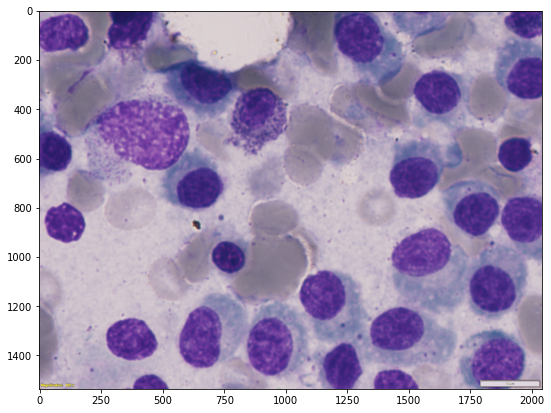

time:-2.934684991836548
[{'boxes': tensor([[ 395.3251, 1080.8256,  799.6414, 1393.6273],
        [ 754.1255,  387.5509, 1111.1552,  739.8708],
        [ 477.8862,  819.1949,  800.6069, 1082.0048],
        [ 364.9580,  405.0294,  746.4548,  741.7091],
        [ 430.7322,  417.1511,  684.4070,  642.1440],
        [ 630.9048,  110.5583,  954.0038,  437.2384],
        [1011.7571,  133.2878, 1325.7996,  493.7406],
        [1086.9617,  142.9816, 1313.5760,  371.1747],
        [ 504.1223, 1170.9281,  761.1199, 1378.7397],
        [1729.1870,  285.4459, 1962.1837,  526.1127],
        [1267.0510,  792.7229, 1543.5048, 1036.1978],
        [1430.1392,  525.9273, 1738.6337,  836.6796],
        [ 555.3076, 1333.1541,  885.3977, 1533.1760],
        [  10.0209,  796.4460,  235.3235, 1050.8218],
        [ 979.0196, 1304.5870, 1284.3303, 1536.0000],
        [ 785.0046,  446.9238,  996.2260,  700.9938],
        [ 464.0682,  347.7637, 1071.4551,  751.0623],
        [ 131.7904, 1009.0427,  312.7054, 1186.

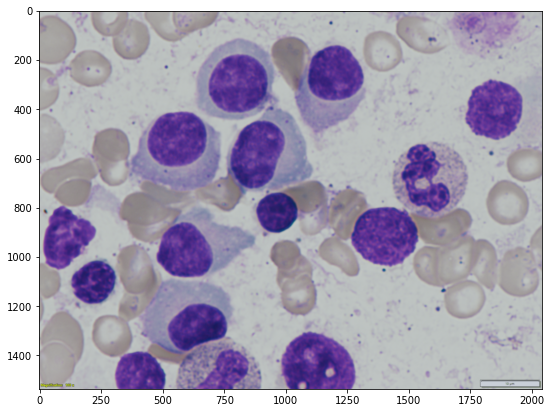

time:-3.0226504802703857
[{'boxes': tensor([[5.4020e+02, 2.2381e+02, 8.0973e+02, 5.3947e+02],
        [9.8892e+02, 0.0000e+00, 1.3126e+03, 2.8464e+02],
        [1.5633e+03, 1.4719e+02, 1.8799e+03, 4.2442e+02],
        [3.2122e+02, 8.7986e+02, 6.4660e+02, 1.1879e+03],
        [3.2176e+02, 1.2198e+03, 6.8099e+02, 1.5323e+03],
        [1.4635e+02, 3.3289e+02, 5.1366e+02, 6.7899e+02],
        [1.1046e+03, 1.0505e+03, 1.3399e+03, 1.2602e+03],
        [0.0000e+00, 1.0116e+02, 2.7736e+02, 3.8923e+02],
        [2.5549e+02, 6.0619e+02, 5.9591e+02, 8.9620e+02],
        [2.9074e+02, 6.9206e+02, 5.1142e+02, 8.8839e+02],
        [9.5556e+02, 8.6547e+02, 1.2568e+03, 1.1366e+03],
        [6.4353e+02, 6.7899e+02, 8.6623e+02, 9.3312e+02],
        [7.1981e+02, 1.0122e+03, 9.3716e+02, 1.2594e+03],
        [3.1870e+02, 1.3211e+03, 5.0269e+02, 1.5304e+03],
        [1.1355e+03, 7.8942e+02, 1.3848e+03, 1.0433e+03],
        [3.7480e+02, 9.0782e+02, 5.9701e+02, 1.1292e+03],
        [9.7585e+02, 8.0010e+02, 1.3

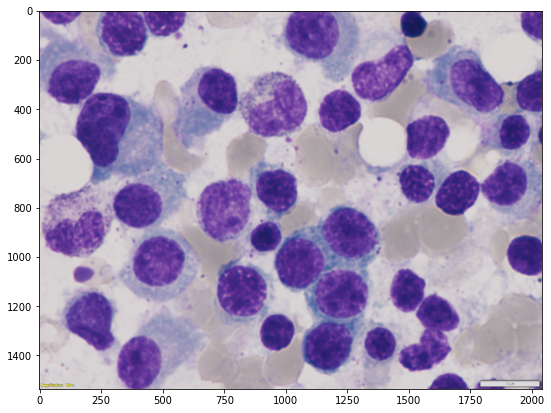

time:-3.124709367752075


In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#CHECKING THE OUTPUT WITH DATASET WITH DATA TRANSFORM
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
import utils
import time
import transforms as T

model.load_state_dict(torch.load('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/weights/Fifth.pth'))

dataset = SegpcDataset('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train', get_transform(train=True))
                                    
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=1,
        collate_fn=utils.collate_fn)
i=-1
for image,target in dataset:
    i+=1
    if i>0:
        if i%40==0:
            tic=time.time()
            img = image
            img = img.permute(1,2,0) 
            img=np.array(img)
            plt.figure(figsize=(9,15))
            plt.imshow(img)
            ax = plt.gca()
            image=[image]
            model.eval()
            output = model(image)
            boxes = output[0]['boxes']
            score = output[0]['scores']
            print(output)
            area = (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])
            for i,box in enumerate(boxes):
                if score[i]>0.6 and area[i]<25000:
                    rect = patches.Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor='g',facecolor='g',alpha=0.13)
                    ax.add_patch(rect)
            plt.show()
            toc=time.time()
            print('time:{}'.format(tic-toc))